## Contrastive Learning in PyTorch with Point Clouds



## Installation / Setup

In [2]:
import torch
import torch_geometric

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

from torch_geometric.nn import GCNConv
print("PyG installed and working. Sample layer:", GCNConv)

Torch version: 2.1.0+cu118
CUDA available: False
GPU: No GPU
PyG installed and working. Sample layer: <class 'torch_geometric.nn.conv.gcn_conv.GCNConv'>


✋ **Note: You'll need to restart your runtime and execute the two cells again.** ✋

## Dataset

Goal:
- Self-Supervised Representation Learning of Shapes
- Can be used for downstream tasks like clustering, fine-tuning, outlier-detection, ...
- Pointcloud = Set of unconnected nodes --> PyG
- [ShapeNet Dataset](https://paperswithcode.com/dataset/shapenet) - we just use a subset of classes and act like we didn't have labels
- I select 5k data points as otherwise I run out of memory on Colab



In [3]:
from torch_geometric.datasets import ModelNet
from torch_geometric.transforms import SamplePoints

# Transform to sample a fixed number of points from the mesh
transform = SamplePoints(1024)

# Load the ModelNet10 dataset
dataset = ModelNet(root="./modelnet", name='10', train=True, transform=transform)

# Shuffle and limit to 5000 samples if needed
dataset = dataset.shuffle()[:15000]

# Print basic info
print("Number of Samples: ", len(dataset))
print("Sample Data Object:\n", dataset[0])


Number of Samples:  3991
Sample Data Object:
 Data(pos=[1024, 3], y=[1])


Attribute Name  | Description
-------------------|------------------
Pos       | Normalized positions as 3D coordinates
X       |  Normal vectors
Y       | Class label

In [4]:
dataset[0].pos

tensor([[ 17.9275, -16.8773,  -8.5441],
        [-24.8642,  12.9990,  -7.4804],
        [-31.1372, -29.6489, -23.5788],
        ...,
        [ -3.5768, -28.4089,  -5.8266],
        [ -4.5351,  22.3727,  -2.5119],
        [  0.2342,  40.0983,  22.0852]])

Let's use plotly to inspect the data ...

In [7]:
#!pip install plotly --quiet
import plotly.express as px

def plot_3d_shape(shape):
    print("Number of data points: ", shape.pos.shape[0])
    x = shape.pos[:, 0]
    y = shape.pos[:, 1]
    z = shape.pos[:, 2]
    fig = px.scatter_3d(x=x, y=y, z=z, opacity=0.3)
    fig.show()

# Pick a sample
sample_idx = 2
plot_3d_shape(dataset[sample_idx])

Number of data points:  1024


In [10]:
# Manually define the categories for ModelNet10 as a workaround
modelnet10_categories = [
    'bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor',
    'night_stand', 'sofa', 'table', 'toilet'
]

# Initialize cat_dict using the hardcoded categories
cat_dict = {key: 0 for key in modelnet10_categories}

# Iterate through datapoints and count categories
for datapoint in dataset:
    # Corrected line: use datapoint.y to get the numerical label
    # and .item() to convert the tensor to a Python integer
    category_index = datapoint.y.item()
    cat_dict[modelnet10_categories[category_index]] += 1

print(cat_dict)

{'bathtub': 106, 'bed': 515, 'chair': 889, 'desk': 200, 'dresser': 200, 'monitor': 465, 'night_stand': 200, 'sofa': 680, 'table': 392, 'toilet': 344}


## Data Preparation

- In some scenarios it makes sense to pre-compute the augmentations (for example if heavy computations are involved)
- This would require to store multiple Data Points in one Data Object, which is possible in PyTorch
- Here we will compute the augmentations on the fly and use the below transformations for this
- Later, for each data point we will need 2 augmentations (positive pair)
- What are good augmentations for Point Clouds?
    - Rotation (if the used layer is not rotation invariant)
    - Jittering (can be seen as adding noise to the coordinates)
    - Shifting / Shearing
    - ... many more




In [11]:
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# We're lucky and pytorch geometric helps us with pre-implemented transforms
# which can also be applied on the whole batch directly
augmentation = T.Compose([T.RandomJitter(0.03), T.RandomFlip(1), T.RandomShear(0.2)])

Let's have a look at some samples ...

In [1]:
# Original data point
sample = next(iter(data_loader))
plot_3d_shape(sample[5])

NameError: name 'data_loader' is not defined

In [13]:
# Augmented data point
transformered = augmentation(sample)
plot_3d_shape(transformered[0])

Number of data points:  1024


## Model

- Different choices for Point Cloud Feature-Learning layers (PointNet, PointNet++, EdgeConv, PointTransformer, ...)
- In PyTorch geometric we find an implementation of DynamicEdgeConv
- It uses the parameter k to detect the nearest neighbors which form a subgraph
- If you have many points, you can also sample a subset
- In the paper they use 4 layers, here we just have 2
- Implementation is inspired by [this PyG example](https://github.com/pyg-team/pytorch_geometric/blob/a6e349621d4caf8b381fe58f8e57109b2d0947ed/examples/dgcnn_segmentation.py)
- We only apply augmentations during training






In [14]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import MLP, DynamicEdgeConv, global_max_pool


class Model(torch.nn.Module):
    def __init__(self, k=20, aggr='max'):
        super().__init__()
        # Feature extraction
        self.conv1 = DynamicEdgeConv(MLP([2 * 3, 64, 64]), k, aggr)
        self.conv2 = DynamicEdgeConv(MLP([2 * 64, 128]), k, aggr)
        # Encoder head
        self.lin1 = Linear(128 + 64, 128)
        # Projection head (See explanation in SimCLRv2)
        self.mlp = MLP([128, 256, 32], norm=None)

    def forward(self, data, train=True):
        if train:
            # Get 2 augmentations of the batch
            augm_1 = augmentation(data)
            augm_2 = augmentation(data)

            # Extract properties
            pos_1, batch_1 = augm_1.pos, augm_1.batch
            pos_2, batch_2 = augm_2.pos, augm_2.batch

            # Get representations for first augmented view
            x1 = self.conv1(pos_1, batch_1)
            x2 = self.conv2(x1, batch_1)
            h_points_1 = self.lin1(torch.cat([x1, x2], dim=1))

            # Get representations for second augmented view
            x1 = self.conv1(pos_2, batch_2)
            x2 = self.conv2(x1, batch_2)
            h_points_2 = self.lin1(torch.cat([x1, x2], dim=1))

            # Global representation
            h_1 = global_max_pool(h_points_1, batch_1)
            h_2 = global_max_pool(h_points_2, batch_2)
        else:
            x1 = self.conv1(data.pos, data.batch)
            x2 = self.conv2(x1, data.batch)
            h_points = self.lin1(torch.cat([x1, x2], dim=1))
            return global_max_pool(h_points, data.batch)

        # Transformation for loss function
        compact_h_1 = self.mlp(h_1)
        compact_h_2 = self.mlp(h_2)
        return h_1, h_2, compact_h_1, compact_h_2

Possible improvement: Only pass once through model by stacking augmentations

## Training

- We use InfoNCE / NT-Xent Loss implemented in pytorch metric learning library
- Temperature allows to balance the similarity measure (make it more peaked)
- Typical values are around 0.1 / 0.2

In [ ]:
# See https://kevinmusgrave.github.io/pytorch-metric-learning/losses/#ntxentloss
# !pip install pytorch-metric-learning -q

from pytorch_metric_learning.losses import NTXentLoss
loss_func = NTXentLoss(temperature=0.10)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

# Use a large batch size (might lead to RAM issues)
# Free Colab Version has ~ 12 GB of RAM
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)


- No test dataset, as the evaluation can be done "downstream"
- The compact representations go into the loss function
- During test time no augmentations are applied and we can use the output representations

In [17]:
import tqdm

def train():
    model.train()
    total_loss = 0
    for _, data in enumerate(tqdm.tqdm(data_loader)):
        data = data.to(device)
        optimizer.zero_grad()
        # Get data representations
        h_1, h_2, compact_h_1, compact_h_2 = model(data)
        # Prepare for loss
        embeddings = torch.cat((compact_h_1, compact_h_2))
        # The same index corresponds to a positive pair
        indices = torch.arange(0, compact_h_1.size(0), device=compact_h_2.device)
        labels = torch.cat((indices, indices))
        loss = loss_func(embeddings, labels)
        loss.backward()
        total_loss += loss.item() * data.num_graphs
        optimizer.step()
    return total_loss / len(dataset)

for epoch in range(1, 4):
    loss = train()
    print(f'Epoch {epoch:03d}, Loss: {loss:.4f}')
    scheduler.step()

100%|██████████| 125/125 [11:17<00:00,  5.42s/it]


Epoch 001, Loss: 2.3005


100%|██████████| 125/125 [10:44<00:00,  5.16s/it]


Epoch 002, Loss: 1.5227


100%|██████████| 125/125 [10:33<00:00,  5.06s/it]

Epoch 003, Loss: 1.2788


## Evaluation of the Embeddings

Shape of embeddings (h): torch.Size([32, 128])
Shape of labels: (32,)


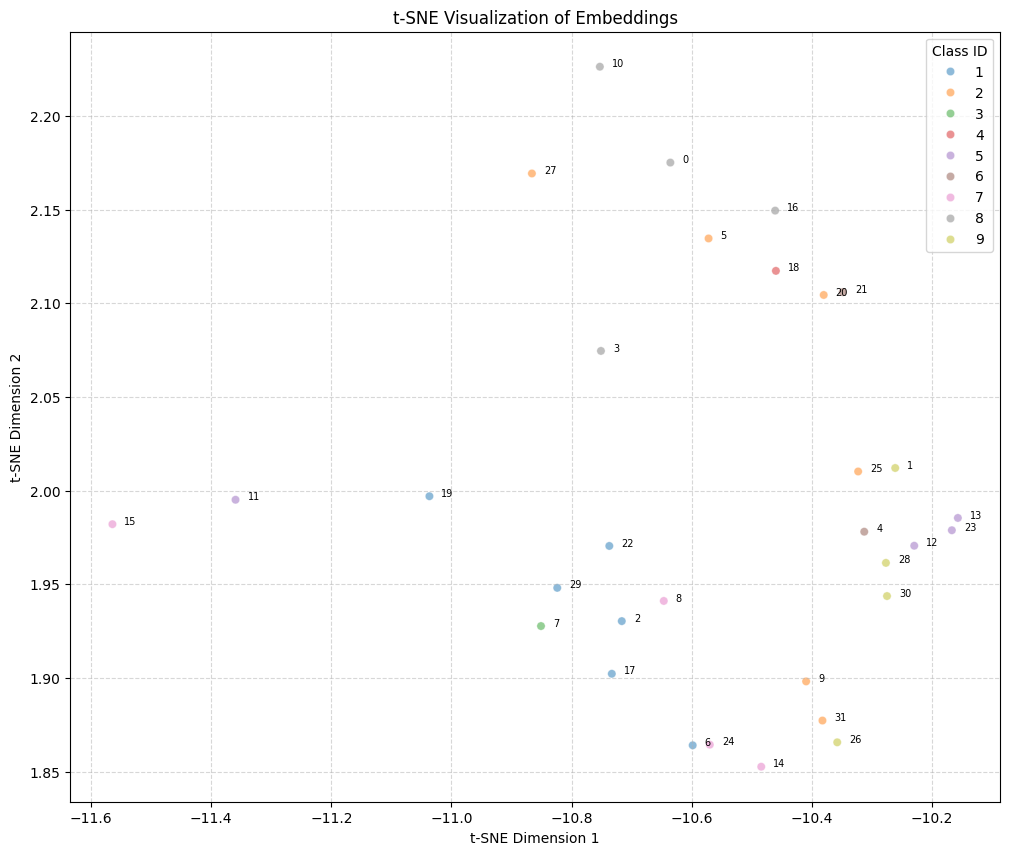

In [33]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import torch # Necessary for .cpu().detach() and .to(device)
import numpy as np # Necessary for .numpy()

# --- Your existing setup (data_loader, model, device) must be defined before this block ---

# Get sample batch
sample = next(iter(data_loader))

# Move the entire sample batch to the appropriate device
sample = sample.to(device)

# Get representations from your model
h = model(sample, train=False)
h = h.cpu().detach()

# --- THE ONLY LINE MODIFIED TO FIX THE AttributeError ---
# As confirmed by your 'sample.keys' output, your labels are in 'sample.y'.
labels = sample.y.cpu().detach().numpy()
# --------------------------------------------------------

print(f"Shape of embeddings (h): {h.shape}")
print(f"Shape of labels: {labels.shape}")

# Get low-dimensional t-SNE Embeddings
h_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random').fit_transform(h.numpy())

# Plot
plt.figure(figsize=(12, 10)) # Added figure creation for proper display
ax = sns.scatterplot(x=h_embedded[:,0], y=h_embedded[:,1], hue=labels,
                    alpha=0.5, palette="tab10")

# Add labels to be able to identify the data points
# This matches your original code: annotations are sequential numbers (0, 1, 2, ...)
annotations = list(range(len(h_embedded[:,0])))

def label_points(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        # Using a slightly smaller font size for better readability if many points
        ax.text(point['x']+.02, point['y'], str(int(point['val'])), fontsize=7)

label_points(pd.Series(h_embedded[:,0]),
            pd.Series(h_embedded[:,1]),
            pd.Series(annotations), # Passing the sequential annotations here
            plt.gca())

plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Class ID") # Legend will show the numerical class IDs
plt.grid(True, linestyle='--', alpha=0.5) # Add a grid for better readability
plt.show() # Display the plot

Let's find the most similar and most different data points ...

[Source](https://stackoverflow.com/questions/50411191/how-to-compute-the-cosine-similarity-in-pytorch-for-all-rows-in-a-matrix-with-re)

In [36]:
import numpy as np

def sim_matrix(a, b, eps=1e-8):
    """
    Eps for numerical stability
    """
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt

similarity = sim_matrix(h, h)
max_indices = torch.topk(similarity, k=2)[1][:, 1]
max_vals  = torch.topk(similarity, k=2)[0][:, 1]

# Select index
idx = 11
similar_idx = max_indices[idx]
print(f"Most similar data point in the embedding space for {idx} is {similar_idx}")

Most similar data point in the embedding space for 11 is 1


Categories are: "Table", "Lamp", "Guitar", "Motorbike", "Skateboard"

**Note**: This is only based on the data in the current batch!

In [37]:
plot_3d_shape(sample[idx].cpu())

Number of data points:  1024


In [38]:
plot_3d_shape(sample[similar_idx].cpu())

Number of data points:  1024


This confirms that our embedding space has a proper arrangement and that our contrastive loss separated different entities successfully.